<a href="https://colab.research.google.com/github/SirwaniViren/MSc-Gousto-Project/blob/main/initial_framework_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import pandas as pd
import random
from collections import defaultdict
from random import randrange
import matplotlib.pyplot as plt

In [ ]:
random.seed(42)

In [ ]:
def create_eligibility_dict(num_factories, num_items):
    items = list(range(100, 100 + num_items * 10, 10))
    eligibility_dict = {}

    # Start with a base number of items for the first factory
    num_eligible_items = random.randint(5, 15)

    for i in range(1, num_factories + 1):
        if i == num_factories:
            # Last factory gets all items
            eligibility_dict[f"F{i}"] = items
        else:
            eligibility_dict[f"F{i}"] = items[:num_eligible_items]
            # Randomly determine the number of additional items for the next factory
            num_eligible_items += random.randint(1, 10)
            # Ensure num_eligible_items does not exceed the total number of items
            num_eligible_items = min(num_eligible_items, num_items)

    return eligibility_dict

In [ ]:
def create_factory_caps(num_factory, max_boxes):
    factory_caps = {}
    # Start with an initial capacity for the first factory
    cap = random.randint(1, max_boxes // 10)  # Starting with a base capacity

    for i in range(1, num_factory + 1):
        if i == num_factory:
            # Last factory gets infinite capacity
            factory_caps[f"F{i}"] = float('inf')
        else:
            factory_caps[f"F{i}"] = cap
            # Randomly increase the capacity for the next factory
            cap += random.randint(1, max_boxes // 10)
            # Ensure the capacity does not exceed max_boxes
            cap = min(cap, max_boxes)

    return factory_caps


def generate_total_boxes(factory_caps, min_extra_boxes, max_extra_boxes):
    # Calculate total capacity excluding the infinite capacity
    finite_capacity = sum(cap for cap in factory_caps.values() if cap != float('inf'))

    # Add a random number of extra boxes to exceed the total capacity
    extra_boxes = random.randint(min_extra_boxes, max_extra_boxes)
    total_boxes = finite_capacity + extra_boxes

    return total_boxes

In [ ]:
def generate_orders(total_boxes, num_items, max_items_per_order=5):
    items = list(range(100, 100 + num_items * 10, 10))
    orders = []
    order_id = 1

    while total_boxes > 0:
        num_items_in_order = min(random.randint(1, max_items_per_order), total_boxes)
        order_items = random.sample(items, num_items_in_order)
        for item in order_items:
            orders.append({'order_id': order_id, 'item_id': item})
        total_boxes -= 1
        order_id += 1

    orders_df = pd.DataFrame(orders)
    return orders_df

In [ ]:
def compute_orders_eligibility(orders_df, eligibility_dict):
    orders_eligibility = []

    for order_id in orders_df['order_id'].unique():
        order_items = orders_df[orders_df['order_id'] == order_id]['item_id'].tolist()
        eligible_factories = []
        for factory, items in eligibility_dict.items():
            if all(item in items for item in order_items):
                eligible_factories.append(factory)
        orders_eligibility.append({'order_id': order_id, 'eligibility': eligible_factories})

    orders_eligibility_df = pd.DataFrame(orders_eligibility)
    return orders_eligibility_df

In [ ]:
eligibility_dict = create_eligibility_dict(20, 100)
factory_caps = create_factory_caps(20, 100)
total_boxes = generate_total_boxes(factory_caps, 1000, 2000)
orders = generate_orders(total_boxes, 100, 5)
order_eligibility = compute_orders_eligibility(orders, eligibility_dict)

# print to check
print(list(eligibility_dict.items())[:10])
print("\n")
print(list(factory_caps.items())[:10])
print("\n")
print(orders.head())
print("\n")
print(order_eligibility.head())


[('F1', [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230]), ('F2', [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280]), ('F3', [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340]), ('F4', [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350]), ('F5', [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410]), ('F6', [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460]), ('F7', [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 4

In [ ]:
def allocate_orders(allocated_orders, allocated_order_eligibility, allocated_factory_caps):

    # Initialize columns
    allocated_orders['site'] = 'not_routed'
    allocated_order_eligibility['allocated'] = False

    # Iterate through each factory except the catch-all
    for factory in list(allocated_factory_caps.keys())[:-1]:
        cap = allocated_factory_caps[factory]

        # Get set S of unrouted orders eligible to the current factory
        eligible_orders = allocated_order_eligibility[(allocated_order_eligibility['allocated'] == False) &
                               (allocated_order_eligibility['eligibility'].apply(lambda i: factory in i))]

        if len(eligible_orders) < cap:
            raise ValueError(f'Not enough eligible orders for {factory}')
        else:
            for _ in range(cap):
                # Pick a random order from the eligible list
                selected_order = eligible_orders.sample(1).iloc[0]
                order_id = selected_order['order_id']

                # Allocate items in df_X
                allocated_orders.loc[orders['order_id'] == order_id, 'site'] = factory

                # Mark the order as allocated in df_Y
                allocated_order_eligibility.loc[allocated_order_eligibility['order_id'] == order_id, 'allocated'] = True

                # Update the eligible_orders to exclude the allocated order
                eligible_orders = eligible_orders[eligible_orders['order_id'] != order_id]

    # Allocate remaining orders to catch-all
    remaining_orders = allocated_order_eligibility[allocated_order_eligibility['allocated'] == False]
    for order_id in remaining_orders['order_id']:
        allocated_orders.loc[orders['order_id'] == order_id, 'site'] = list(allocated_factory_caps.keys())[-1]
        allocated_order_eligibility.loc[allocated_order_eligibility['order_id'] == order_id, 'allocated'] = True

    return allocated_orders


In [ ]:
ld10_allocation = allocate_orders(orders.copy(), order_eligibility.copy(), factory_caps.copy())
ld5_allocation = allocate_orders(orders.copy(), order_eligibility.copy(), factory_caps.copy())
ld0_allocation = allocate_orders(orders.copy(), order_eligibility.copy(), factory_caps.copy())

In [ ]:
def aggregate_items(allocated_orders_df, day):
    lead_day = 'lead_' + str(day)
    aggregated_df = allocated_orders_df.groupby(['item_id', 'site']).size().reset_index(name=lead_day)
    return aggregated_df

In [ ]:
aggregated_ld10 = aggregate_items(ld10_allocation, 10)
aggregated_ld5 = aggregate_items(ld5_allocation, 5)
aggregated_ld0 = aggregate_items(ld0_allocation, 0)

In [ ]:
def merge_allocation(soft_df, hard_df, soft_num, hard_num):
    soft_day = 'lead_' + str(soft_num)
    hard_day = 'lead_' + str(hard_num)
    # Merge the two dataframes on 'item_id' and 'site'
    merged_df = pd.merge(soft_df, hard_df, on=['item_id', 'site'], how='outer')

    # Fill NaN values with zeros
    merged_df.fillna(0, inplace=True)

    # Ensure the integer type for lead_5 and lead_0 columns
    merged_df[soft_day] = merged_df[soft_day].astype(int)
    merged_df[hard_day] = merged_df[hard_day].astype(int)

    return merged_df

In [ ]:
# Merge the dataframes and calculate the absolute error
merged_10_0_df = merge_allocation(aggregated_ld10, aggregated_ld0, soft_num=10, hard_num=0)
merged_5_0_df = merge_allocation(aggregated_ld5, aggregated_ld0, soft_num=5, hard_num=0)

In [ ]:
def calculate_wmape_site(merged_df, soft_col, hard_col):
    total_forecast = merged_df["lead_0"].sum()
    site_df = merged_df.copy()
    site_df['abs_error'] = (site_df[soft_col] - site_df[hard_col]).abs()

    # Calculate WMAPE_site
    wmape_site = site_df["abs_error"].sum() / total_forecast

    return site_df, wmape_site

In [ ]:
def calculate_wmape_global(merged_df, soft_col, hard_col):
    total_forecast = merged_df["lead_0"].sum()
    global_df = merged_df.copy()
    global_df = global_df.groupby('item_id').sum().reset_index()
    global_df['abs_error'] = (global_df[soft_col] - global_df[hard_col]).abs()
    global_df = global_df.drop(['site'], axis=1, errors='ignore')

    # Calculate WMAPE_global
    wmape_global = global_df["abs_error"].sum() / total_forecast

    return global_df, wmape_global

In [ ]:
site_10_0_df, wmape_10_0_site = calculate_wmape_site(merged_10_0_df, soft_col='lead_10', hard_col='lead_0')
global_10_0_df, wmape_10_0_global = calculate_wmape_global(merged_10_0_df, soft_col='lead_10', hard_col='lead_0')
site_5_0_df, wmape_5_0_site = calculate_wmape_site(merged_5_0_df, soft_col='lead_5', hard_col='lead_0')
global_5_0_df, wmape_5_0_global = calculate_wmape_global(merged_5_0_df, soft_col='lead_5', hard_col='lead_0')

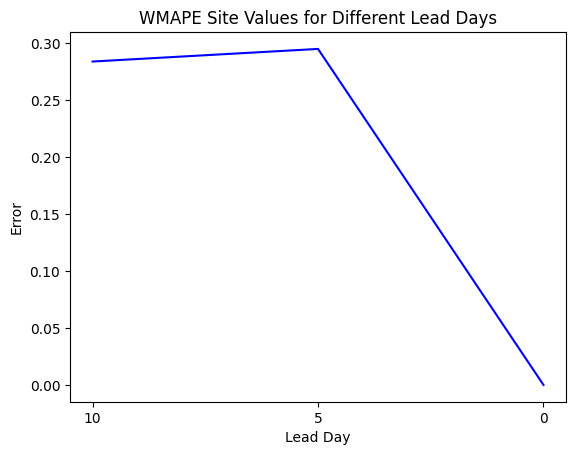

In [ ]:
lead_days = [10, 5, 0]
wmape_values = [wmape_10_0_site, wmape_5_0_site, 0]

# Plot the data
plt.plot(lead_days, wmape_values, linestyle='-', color='b')
plt.xlabel('Lead Day')
plt.ylabel('Error')
plt.title('WMAPE Site Values for Different Lead Days')
plt.xticks([10, 5, 0])
plt.gca().invert_xaxis()  # Invert x-axis to have 0 at the end
plt.show()